<table width=100%>
<tr>
<td width=60%>
<h1><b>MET/MATT - Computer Vision <br>
with Deep Learning</b></h1>
<h4>2023 - Ayan Banerjee under supervision of Josep Ramon Morross
<br>
<a href="https://imatge.upc.edu/web/"> GPI @ IDEAI</a> Research group
<a href="https://telecos.upc.edu/ca">ETSETB – UPC.TelecosBCN</a></h4>
</td>
<td style="text-align: right;" width=40%>
<img src="https://drive.google.com/uc?export=view&id=1tAyPa600X2kvCmWEIPbkdDGFgZPaMziC" width=300>
</td>
</tr>
</table>

We will be using the some additional images and videos. First of all download them from ATENEA and upload them to this Colaboratory notebook using the menu on the left (click the folder icon <img src="https://drive.google.com/uc?export=view&id=1vhCTzgZ1XLyig-aLwxM0wc1l4d7tBPrd" width=15>, upload the particle_filters.zip file). Wait until the upload is complete, it may take some time.
Decompress the zip file to use its contents:`

# Montecarlo methods

### Approximating a simple pdf: gaussian

Let's try to approximate a pdf p(x) assuming that we can sample from it. We wil use a simple case: a gaussian pdf. 

$p(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2 \sigma^2}}$

We can sample a gaussian pdf using a gaussian random number generator. 

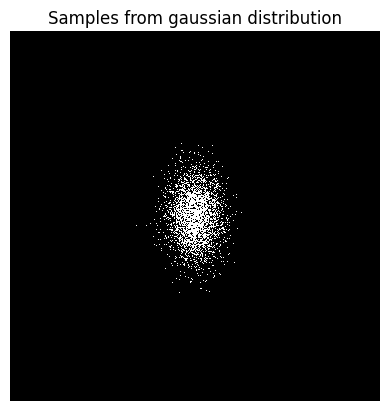

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from display_images import display_image

rng = np.random.default_rng(seed=42)
samples = rng.multivariate_normal((0,0), [[210,0],[0,630]], 4000)

# Quantize to represent as image coordinates
samples = np.round(samples).astype(int)
ima = np.zeros((400,400))
ima[samples[:,1]+200, samples[:,0]+200] = 255

display_image(ima, 'Samples from gaussian distribution')

The samples are concentrated on the compact set of the distribution and offer a good approximation. This is obvious by looking at the histogram of the samples:

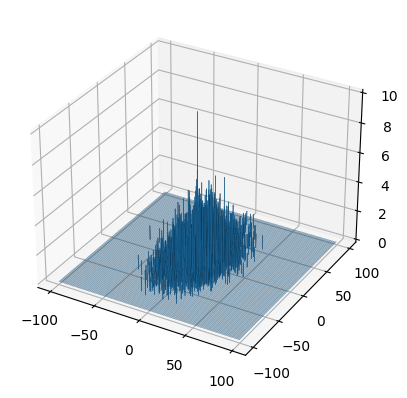

In [4]:
xedges = np.linspace(-100,100,201) 
yedges = np.linspace(-100,100,201)

histmat, xedges, yedges = np.histogram2d(samples[:,0], samples[:,1], bins=(xedges, yedges))


# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = histmat.ravel()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

### Approximating a complex distribution

Let's try with a more complex pdf. We will assume that we know the shape of the pdf (in most cases we do not, this is precisely what we are looking for). 

$\tilde{p}(x) = e^{0.4(x-0.4)^2 - 0.08x^4}$

sampling this distribution is not straighforward. In most cases it will be difficult or impossible. We can sample from another distribution q(x), called *importance distribution*.

Note that, to make things worse, the distribution is unnormalized. To normalize it, we should compute the normalizing constant $Z$ as:

$p(x) = \frac{\tilde{p}(x)}{Z_1}$

$Z_1 = \int_{-\infty}^{+\infty} \tilde{p}(x)dx$

In this case, it is possible to compute Z (it is ~7.8522) but in more complex cases, specially in the multidimensional case, it is not.

### Importance distribution: uniform

Let's try first sampling from an uniform distribution. The probability density function of the uniform distribution is

$\tilde{q}(x) = 1$

In [5]:
import numpy as np

a = -20
b =  20
num_lin_samples = 4000

rng = np.random.default_rng(seed=42)

lin_samples = rng.uniform(a,b,num_lin_samples) 
lin_samples.sort()

Note that in this particular case, it can be detrmined that the normalization constant is:

$ Z_2 = \int_{a}^{b} 1 dx = b-a$


In [6]:
z1 = 7.8522  # Integral computed with https://www.wolframalpha.com/: integrate  exp(0.4*(x-0.4)**2 - 0.08 * x**4) from -infinity to infinity
z2 = b-a

In this case, the histogram does not provide a good representation of the pdf (it is a flat histogram!). To compensate for the mismatch between p(x) and q(x), we can apply a weight to each sample:

$ \tilde{w}(x) = \frac{\tilde{p}(x)}{\tilde{q}(x)}$

Note that these are the unnormalized weights

In [7]:
pun = np.exp(0.4*(lin_samples-0.4)**2 - 0.08 * lin_samples**4)
qun = np.ones(num_lin_samples)
weights = pun / qun

We can normalize the weights:

In [8]:
sumw =  np.sum(weights)
nweights = weights / sumw

We can compare this approximated normalization factor with the 'true' normalization factor $\frac{Z_2}{Z_1}$ computed using the integrals:

In [9]:
# Approximated normalization constant
print ('Approximated normalization constant = {}'.format(num_lin_samples/sumw))

# True normalizing constant (conputed with the integrals)
print ('True normalization constant = {}'.format(z2/z1))

Approximated normalization constant = 4.921904819061738
True normalization constant = 5.094113751560072


The set of weighted samples provides a better approximation of p(x). To demonstrate this, let's plot the weighted histogram:

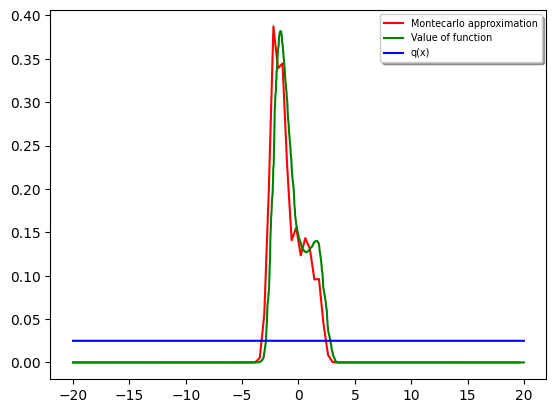

In [10]:
import matplotlib.pyplot as plt

num_bins = 100
xedges = np.linspace(a,b,num_bins) 

histmat, xedges = np.histogram(lin_samples, bins=xedges, weights = nweights)
histmat = histmat * (num_bins/z2) # correct histogram samples

fig, ax = plt.subplots()
ax.plot(xedges[:-1],histmat, 'r', label='Montecarlo approximation')
ax.plot(np.linspace(a,b,num_lin_samples), (np.exp(0.4*(lin_samples-0.4)**2 - 0.08 * lin_samples**4)/z1), 'g', label="Value of function")
ax.plot(np.linspace(a,b,num_lin_samples), np.ones(num_lin_samples)/z2, 'b', label="q(x)")

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-small')

plt.show()

### Inportance distribution: two gaussians

Let's try with two gaussians, one centered near the first node (the maximum of p(x)), $x=-1.7523$ and one centered at the second node, $x = 1.4$

The importance function is given by:

$q(x) = (1 - \alpha) e^{-\frac{(x+1.7523)^2}{2\sigma_1^2}} + \alpha e^{-\frac{(x+1.4)^2}{2\sigma_2^2}}$ 

The normalization factor (computed with https://www.wolframalpha.com) is:

$Z_2 = \int_a^b q(x) dx = 2.5$

In [11]:
mu1         = -1.7523
sigma1      = 1.0
mu2         = 1.4
sigma2      = 1.0
num_samples = 4000
num_samples1 = int(np.round(num_samples*2/3))
num_samples2 = num_samples-num_samples1

rng         = np.random.default_rng(seed=42)
samples1    = rng.normal(mu1, sigma1, num_samples1)
samples2    = rng.normal(mu2, sigma2, num_samples2)
samples     = np.concatenate([samples1,samples2])
samples.sort()

# Evaluation of unnormalized p(x)
pun = np.exp(0.4*(samples-0.4)**2 - 0.08 * samples**4) 

alpha = 0.3  # Combination of the two gaussians 

z2 = 2.5 # https://www.wolframalpha.com "integrate  0.7 * exp (-((x+1.7523)^2 / (2))) + 0.3 * exp (-((x-1.4)^2 / (2))) from -infinity to infinity"

# Evaluation of unnormalized q(x)
qun = (1. - alpha) * np.exp (-((samples-mu1)**2 / (2*sigma1**2))) + alpha * np.exp (-((samples-mu2)**2 / (2*sigma2**2)))

# unnormalized weights
weights = pun / qun

sumw =  np.sum(weights)
nweights = weights / sumw

# Approximated normalization constant
print ('Approximated normalization constant = {}'.format(num_samples/sumw))

# True normalizing constant (conputed with the integrals)

print ('True normalization constant = {}'.format(2.5 / z1))

Approximated normalization constant = 0.3210178883057127
True normalization constant = 0.3183821094725045


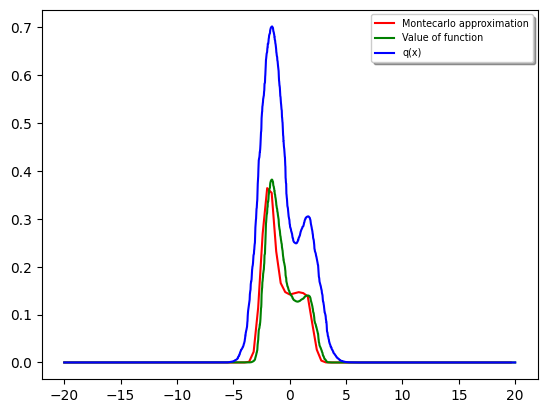

In [12]:
xedges = np.linspace(a,b,101) 

histmat, xedges = np.histogram(samples, bins=xedges, weights = nweights)
histmat = histmat * (num_bins/(b-a)) # correct histogram samples

fig, ax = plt.subplots()

ax.plot(xedges[:-1], histmat, 'r', label ='Montecarlo approximation')
ax.plot(np.linspace(a,b,num_lin_samples), np.exp(0.4*(lin_samples-0.4)**2 - 0.08 * lin_samples**4)/z1, 'g', label='Value of function')
ax.plot(np.linspace(a,b,num_lin_samples), (1. - alpha) * np.exp (-((lin_samples-mu1)**2 / (2*sigma1**2))) + alpha * np.exp (-((lin_samples-mu2)**2 / (2*sigma2**2))), 'b', label='q(x)')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-small')

plt.show()

This importance distribution offers a better approximation that the uniform distribution because is more similar to p(x).

# Particle filters

We need to install an additional package: filterpy

## Sampling

For this case, the state vector will consist of just the position. Let's assume we have a set of 2D particles (just position) and the associated weights:

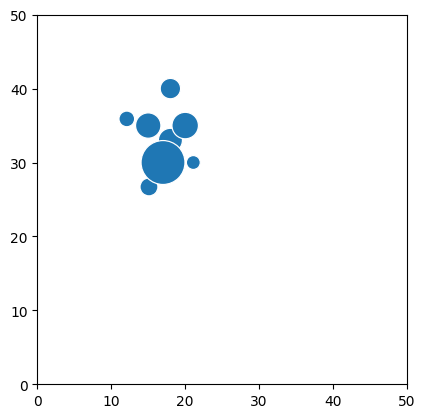

In [13]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

num_particles = 8
particles = np.array([[21.1,30.0], [15.1,26.7], [12.1,35.9], [18,40], [18,33], [15,35], [20,35], [17,30]])
weights = np.array([3, 25, 12, 41, 69, 80, 90, 300])
weights = weights / np.sum(weights)

# use the scatterplot function to build the bubble map
h = sns.scatterplot(x=particles[:,0], y=particles[:,1], size=weights, legend=False, sizes=(100, 1000))
h.set_aspect('equal')
h.set(xlim=(0, 50))
h.set(ylim=(0, 50))

# show the graph
plt.show()

Let's compute the ESS to check for degeneracy:

In [14]:
ESS = 1.0 / np.sum(weights**2)
print ('ESS = {}'.format(ESS))

ESS = 3.4407447189402074


ESS is smaller than $N/2$ so we will resample, Resampling works by removing some particles and splitting the remaining ones. 

Let's implement a function to perform the resampling. For the SIR particle filter, the function only needs to know the weights.

In [20]:
import numpy as np

# A resampling implementation 
def sampling(weights, seed=None):

    if seed != None:
        #Initialize the random number generator                                                                                              
        rng = np.random.default_rng(seed=seed)
    else:
        rng = TO_DO

    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
    num_particles = len(weights)

    cdf     = np.zeros(num_particles)
    uu      = np.zeros(num_particles)
    parents = np.zeros(num_particles, dtype=int)

    # construct CDF                                                                                                                          
    for ii in range(1, num_particles):
        cdf[ii] = cdf[ii-1] + weights[ii]
    print ('cdf     = ', cdf)

    ii = 0
    uu[0] = rng.uniform(0, 1/num_particles)
    for jj in range(0, num_particles):
        uu[jj] = uu[0] + (1./num_particles) * jj
        while uu[jj] > cdf[ii]:
            ii = ii + 1
        parents[jj] = ii

    print ('uu      = ', uu)
    return parents

Let's try the function with the given particles: 

In [21]:
# Control the number of decimals when printing float arrays
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print ('weights = ', weights)
indices = sampling(weights, seed=20)
print ('Resampled indices = ', indices)

weights =  [0.005 0.040 0.019 0.066 0.111 0.129 0.145 0.484]
cdf     =  [0.000 0.040 0.060 0.126 0.237 0.366 0.511 0.995]
uu      =  [0.035 0.160 0.285 0.410 0.535 0.660 0.785 0.910]
Resampled indices =  [1 4 5 6 7 7 7 7]


The resampling function returns the indices of the surviving particles. Note that there are indices that appear several times. They correspond to splitted particles.

Now, let's perform the resampling using a library function:

In [22]:
from filterpy import monte_carlo

idx_resampling = monte_carlo.resampling.residual_resample(weights)

print ('Indices of resamples particles:')
print (idx_resampling)

new_particles = particles[idx_resampling]
print ('New set of particles')
print (new_particles)

# All resulting particles are re-weighted
new_weights = np.ones(num_particles) * (1.0/num_particles)  

Indices of resamples particles:
[5 6 7 7 7 7 5 7]
New set of particles
[[15.000 35.000]
 [20.000 35.000]
 [17.000 30.000]
 [17.000 30.000]
 [17.000 30.000]
 [17.000 30.000]
 [15.000 35.000]
 [17.000 30.000]]


The following step is to apply some noise to the state of the particles, before the propagation.

In [23]:
# Apply difussion:
rng = np.random.default_rng(seed=42)
sigma = 1
new_particles_dif = rng.normal(new_particles, sigma)

print ('New diffused particles')
print (new_particles_dif)

New diffused particles
[[15.305 33.960]
 [20.750 35.941]
 [15.049 28.698]
 [17.128 29.684]
 [16.983 29.147]
 [17.879 30.778]
 [15.066 36.127]
 [17.468 29.141]]


Now, let's plot the particles:

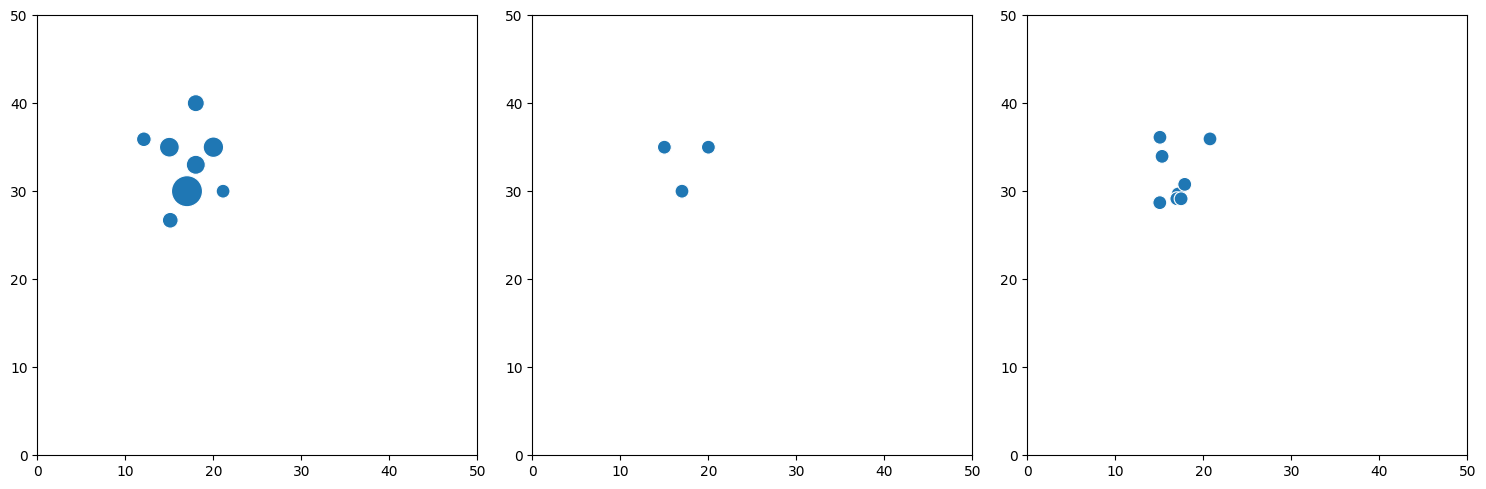

In [24]:
# use the scatterplot function to build the bubble map
fig, axs = plt.subplots(1,3)
h1 = sns.scatterplot(x=particles[:,0], y=particles[:,1], size=weights, legend=False, sizes=(100, 500), ax=axs[0])
h2 = sns.scatterplot(x=new_particles[:,0], y=new_particles[:,1], size=new_weights, legend=False, sizes=(100, 500), ax=axs[1])
h3 = sns.scatterplot(x=new_particles_dif[:,0], y=new_particles_dif[:,1], size=new_weights, legend=False, sizes=(100, 500), ax=axs[2])
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')

axs[0].axes.set_xlim(0,50)
axs[0].axes.set_ylim(0,50)

axs[1].axes.set_xlim(0,50)
axs[1].axes.set_ylim(0,50)

axs[2].axes.set_xlim(0,50)
axs[2].axes.set_ylim(0,50)

h1.figure.set_figwidth(15)
h2.figure.set_figwidth(15)
h3.figure.set_figwidth(15)

plt.tight_layout()

# show the graph
plt.show()

## Particle filter without a motion model

In this example, we will compute two iterations of a particle filter to track a car. We assume that the state vector at k=0 is known. If we do not know the motion model followed by the object, we can use simply a gaussian diffusion to propagate the particles between time instants. We will represent the car using a rectangular bounding box. In ths case, the state vector $x$ is

$x = [c_x, c_y, w/2, h/2]$

where $c_x,c_y$ are the coordinates of the center of the bbox, and $w, h$ are the wieht and height of the bbox.



In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's define some parameters:

In [26]:
num_particles = 20
sigma = [10,16,2,1]               # Varianves along the different dimensions
state0 = np.array([551,259,15,9]) # state vector at k=0. 

Note that as we rely solely on the gaussian difussion to propagate the particles, we need large values for the variace (sigma). 

In [27]:
# Ground Truth: True states for three frames: [cx,cy,w/2,h/2]
# Obtained manually
tst = np.array([[551,259,15,9],[545,265,17,10],[537,272,18,10]])

name0 = 'out_000001.png'  # image at k=0

# Read the first image. OpenCV reads in BGR format
ima0 = cv2.imread(name0)
# Convert image to L·a·b color space
ima0_lab = cv2.cvtColor(ima0,cv2.COLOR_BGR2Lab)
# Keep an rgb image for visualization
ima0_rgb = cv2.cvtColor(ima0,cv2.COLOR_BGR2RGB)

# Create a model of the objec to follow by cropping the image using the state at k=0 
model = ima0_lab[tst[0,1]-tst[0,3]:tst[0,1]+tst[0,3]+1,tst[0,0]-tst[0,2]:tst[0,0]+tst[0,2]+1,:]

# Dynamic ranges for the a and b channels in Lab color space
ranges = [100, 171, 80, 180]  # These are particular for this sequence. 
                              # For the general case use [0,256,0,256]
#ranges = [0, 256, 0, 256]


# Compute a bidimensional histogram using the channels a and b. We are using
# 16 bins along each dimension of the histogram
target_hist = cv2.calcHist( [model], [1, 2], None, [16,16], ranges)
# Normalize histogram
target_hist = target_hist.flatten() / np.sum(target_hist.flatten()) 


# Create a set of particles by repeating the state at k=0
particles0 = np.repeat([state0],num_particles, axis=0)

# Apply difussion to the particles using a normal distribution centered in each particle
rng = np.random.default_rng(seed=42)
particles0 = rng.normal(particles0, sigma)

# Assign equal weights to the particles
weights0   = 1.0 / num_particles

display_image(ima0_rgb, 'Initial state', size=1.0)

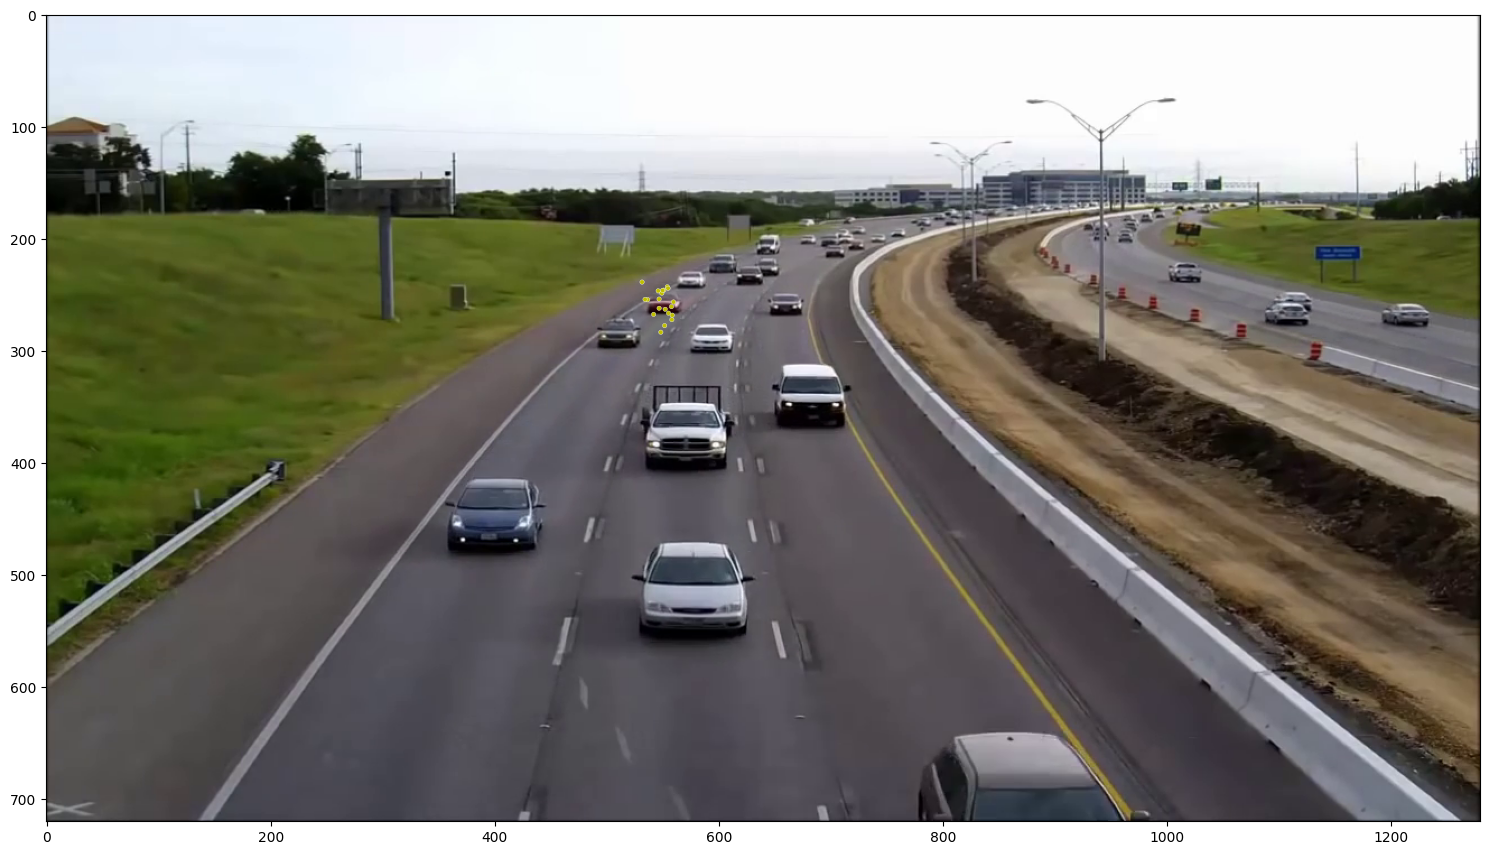

In [28]:
# Plot the resulting set of particles. The diameter of the circles indicates the weight
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(ima0_rgb)
sns.scatterplot(x=particles0[:,0], y=particles0[:,1], size=weights0, color = 'y', legend=False, sizes=(10, 500), ax=ax)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

Now, the we step from $k=0$ to $k=1$:

In [30]:
# Receive an observation for current time instant
name1 = 'out_000010.png'  # image at k=1  
ima1  = cv2.imread(name1)

# Convert image to L·a·b color space
ima1_lab = cv2.cvtColor(ima1,cv2.COLOR_BGR2Lab)
ima1_rgb = cv2.cvtColor(ima1,cv2.COLOR_BGR2RGB)
ima1_rgb_rect = ima1_rgb.copy()

# No motion model. To change the position of the particles, we will do with the difussion in the previous step
particles1 = particles0.astype(int)

epsilon = 0.000001 # Small constant to avoid division by zero

likelihood = np.zeros(num_particles)
for ii in range(num_particles):
    # Crop the particle from the image
    model = ima1_lab[particles1[ii,1]-particles1[ii,3]:particles1[ii,1]+particles1[ii,3]+1,particles1[ii,0]-particles1[ii,2]:particles1[ii,0]+particles1[ii,2]+1,:]
    # Compute the histogram of the particle
    particle_hist = cv2.calcHist( [model], [1, 2], None, [16,16], ranges)
    particle_hist = particle_hist.flatten() / (np.sum(particle_hist.flatten())+epsilon) # Normalize histogram

    # Compute likelihood of the particle: compare the histogram of the particle 
    # and the histogram of the initial model
    likelihood[ii] = cv2.compareHist(target_hist, particle_hist, cv2.HISTCMP_INTERSECT)

# Normalize likelihoods and compute normalized weights
weights1 = likelihood / np.sum(likelihood)


At this point, we can estimate the state for k=1. We will consider two methods: the average of al the particles and the particle with larger weight.

To analyze the results we will use the $IoU$ (Intersection over Union) metric, which is commonly used in object detection. Note that an $IoU \geq 0.5$ is usually considered a correct detection.

In [31]:
from iou import iou  # To use this, you must upload the file iou.py to Colab

# Estimate state: averaged sum
state_avg = np.sum(particles1 * weights1[:,None], axis=0).astype(int)

# Estimate state: particle with largest weight
state_lw = particles1[np.argmax(weights1)]

print ('Average:        ', state_avg)
print ('Highest weight: ', state_lw)
print ('True state:     ', tst[1,:])

# Bounding box of the true state
bb_tst = {'x1':tst[1,0]-tst[1,2], 'y1':tst[1,1]-tst[1,3],'x2':tst[1,0]+tst[1,2], 'y2':tst[1,1]+tst[1,3]}
# Bounding box of the solution using the average
bb_avg = {'x1':state_avg[0]-state_avg[2], 'y1':state_avg[1]-state_avg[3], 'x2':state_avg[0]+state_avg[2], 'y2':state_avg[1]+state_avg[3]}
# Bounding box of the solution using the largest weight
bb_lw  = {'x1':state_lw[0]-state_lw[2], 'y1':state_lw[1]-state_lw[3], 'x2':state_lw[0]+state_lw[2], 'y2':state_lw[1]+state_lw[3]}

# Compute Intersection over Union to evaluate the solution. Higher values are 
# better. IoU is bounded in [0,1]. In object detection an IoU >= 0.5 is usually 
# considered a correct detection.
print ('IOU avg  = {:.3f}'.format(iou(bb_tst, bb_avg)))
print ('IOU best = {:.3f}'.format(iou(bb_tst, bb_lw)))


Average:         [549 258  15   8]
Highest weight:  [541 266  15   9]
True state:      [545 265  17  10]
IOU avg  = 0.323
IOU best = 0.615


We can visualize the weights and the particles on $k=1$:

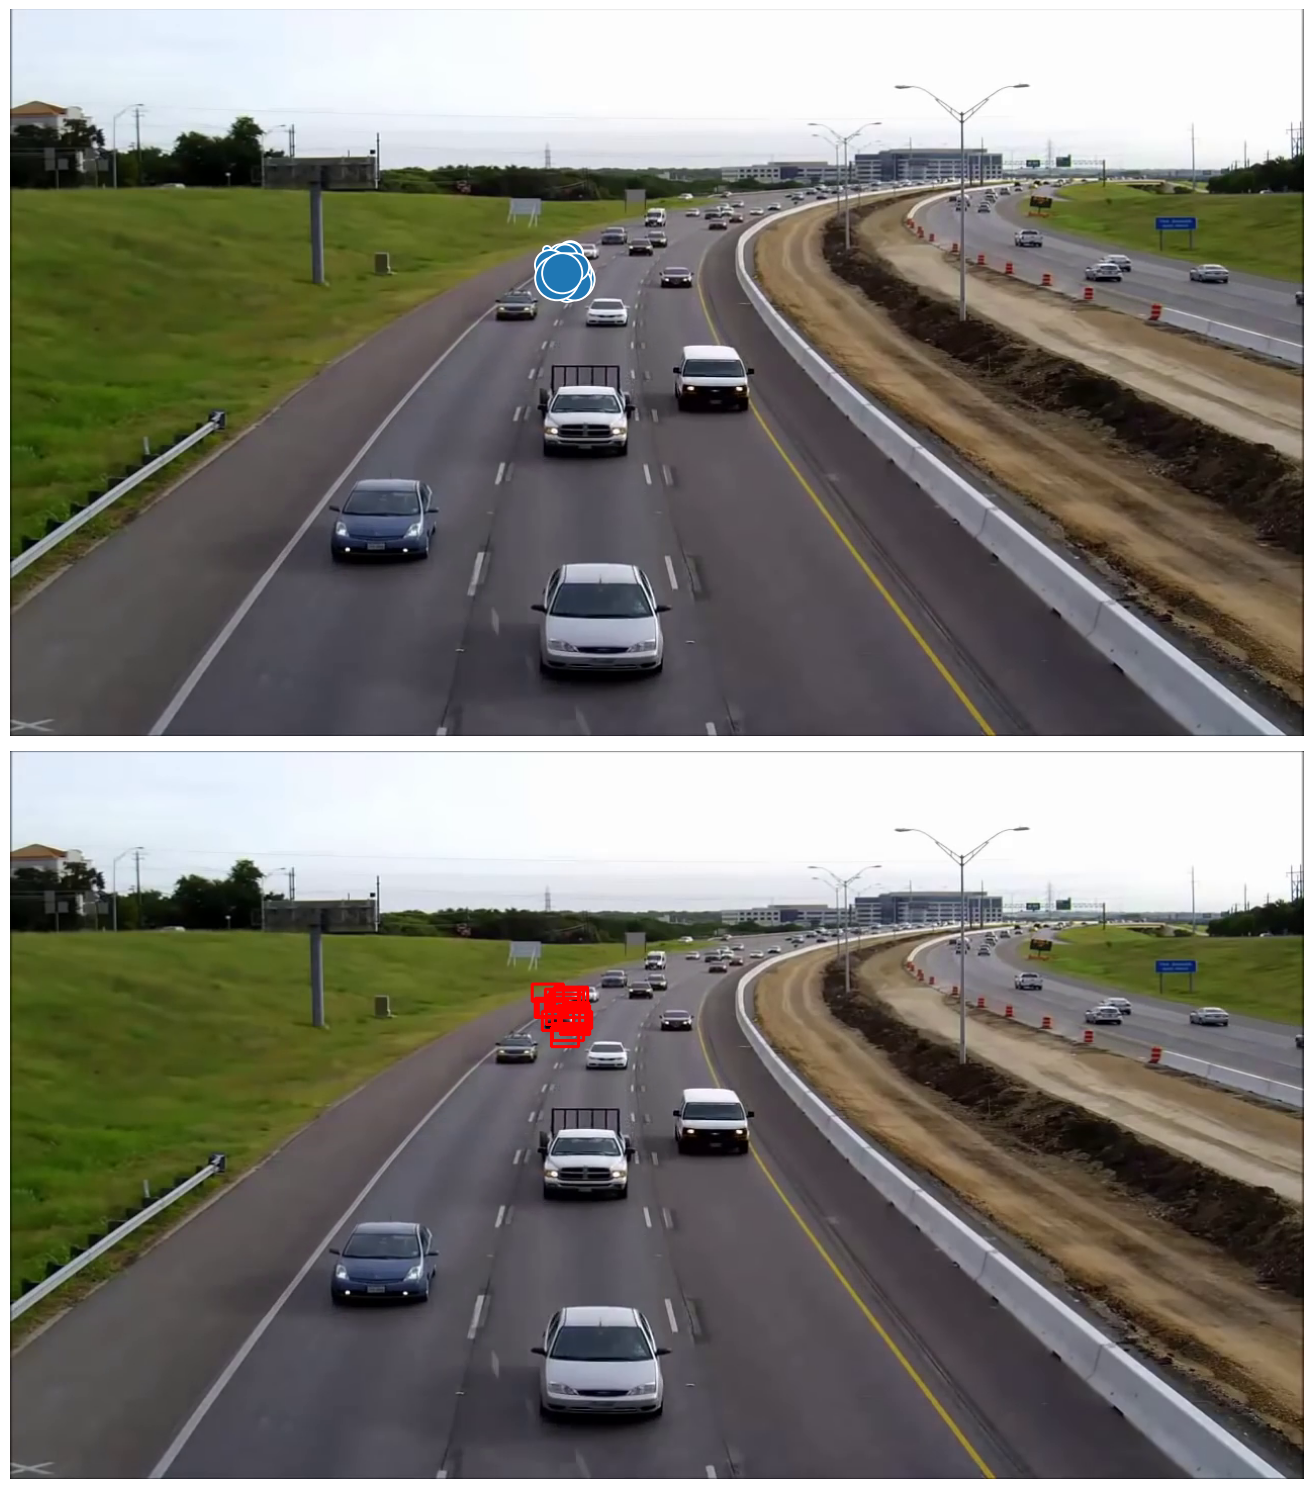

In [32]:
for ii in range(num_particles):
    cv2.rectangle(ima1_rgb_rect,(particles1[ii,0]-particles1[ii,2], particles1[ii,1]-particles1[ii,3]),(particles1[ii,0]+particles1[ii,2]+1, particles1[ii,1]+particles1[ii,3]+1),(255,0,0),2)

# Visualize 
fig,ax = plt.subplots(2,1,figsize=(15,15))
ax[0].imshow(ima1_rgb)
ax[0].set_axis_off()
sns.scatterplot(x=particles1[:,0], y=particles1[:,1], size=weights1, legend=False, sizes=(10, 1000), ax=ax[0])

ax[1].imshow(ima1_rgb_rect)
ax[1].set_axis_off()

plt.tight_layout()

# show the graph
plt.show()

To improve the visualization, we can zoom in the region around the car:

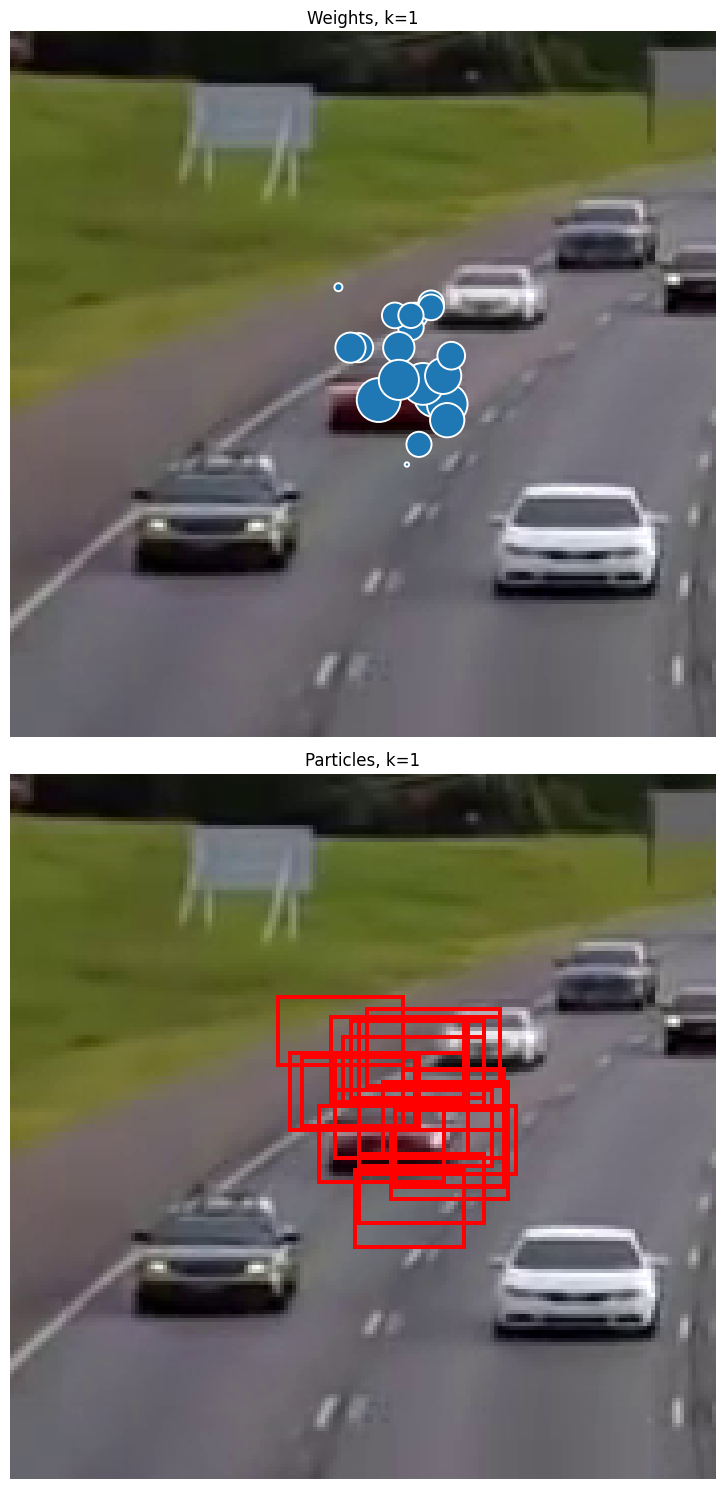

In [33]:
# Zoom of the interest region. Not useful if the number of particles is large

ima1_crop       = ima1_rgb[175:350, 450:625]
ima1_rect_crop  = ima1_crop.copy()
particles1_crop = particles1.copy()

for ii in range(num_particles):
    # Correct the coordinates
    particles1_crop[ii,0:2] = particles1_crop[ii, 0:2] - np.array([450,175])
    # Draw a rectangle over the image
    cv2.rectangle(ima1_rect_crop,(particles1_crop[ii,0]-particles1_crop[ii,2], particles1_crop[ii,1]-particles1_crop[ii,3]),(particles1_crop[ii,0]+particles1_crop[ii,2]+1, particles1_crop[ii,1]+particles1_crop[ii,3]+1),(255,0,0),1)


fig,ax = plt.subplots(2,1,figsize=(15,15))
ax[0].imshow(ima1_crop)
sns.scatterplot(x=particles1_crop[:,0], y=particles1_crop[:,1], size=weights1, legend=False, sizes=(10, 1000), ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Weights, k=1')

ax[1].imshow(ima1_rect_crop)
ax[1].set_axis_off()
ax[1].set_title('Particles, k=1')

plt.tight_layout()
plt.show()

We can also plot each particle separately. NOTE: this may result in unmanageable cells if the number of particles is too large.

<ipython-input-34-08241f9deb13>:17: MatplotlibDeprecationWarning: The resize method was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use FigureManagerBase.resize instead.
  h.figure.canvas.resize(ima1_crop.shape[1] + 1, ima1_crop.shape[0] + 1)
<ipython-input-34-08241f9deb13>:31: MatplotlibDeprecationWarning: The resize method was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use FigureManagerBase.resize instead.
  h.figure.canvas.resize(ima1_crop.shape[1] + 1, ima1_crop.shape[0] + 1)
<ipython-input-34-08241f9deb13>:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


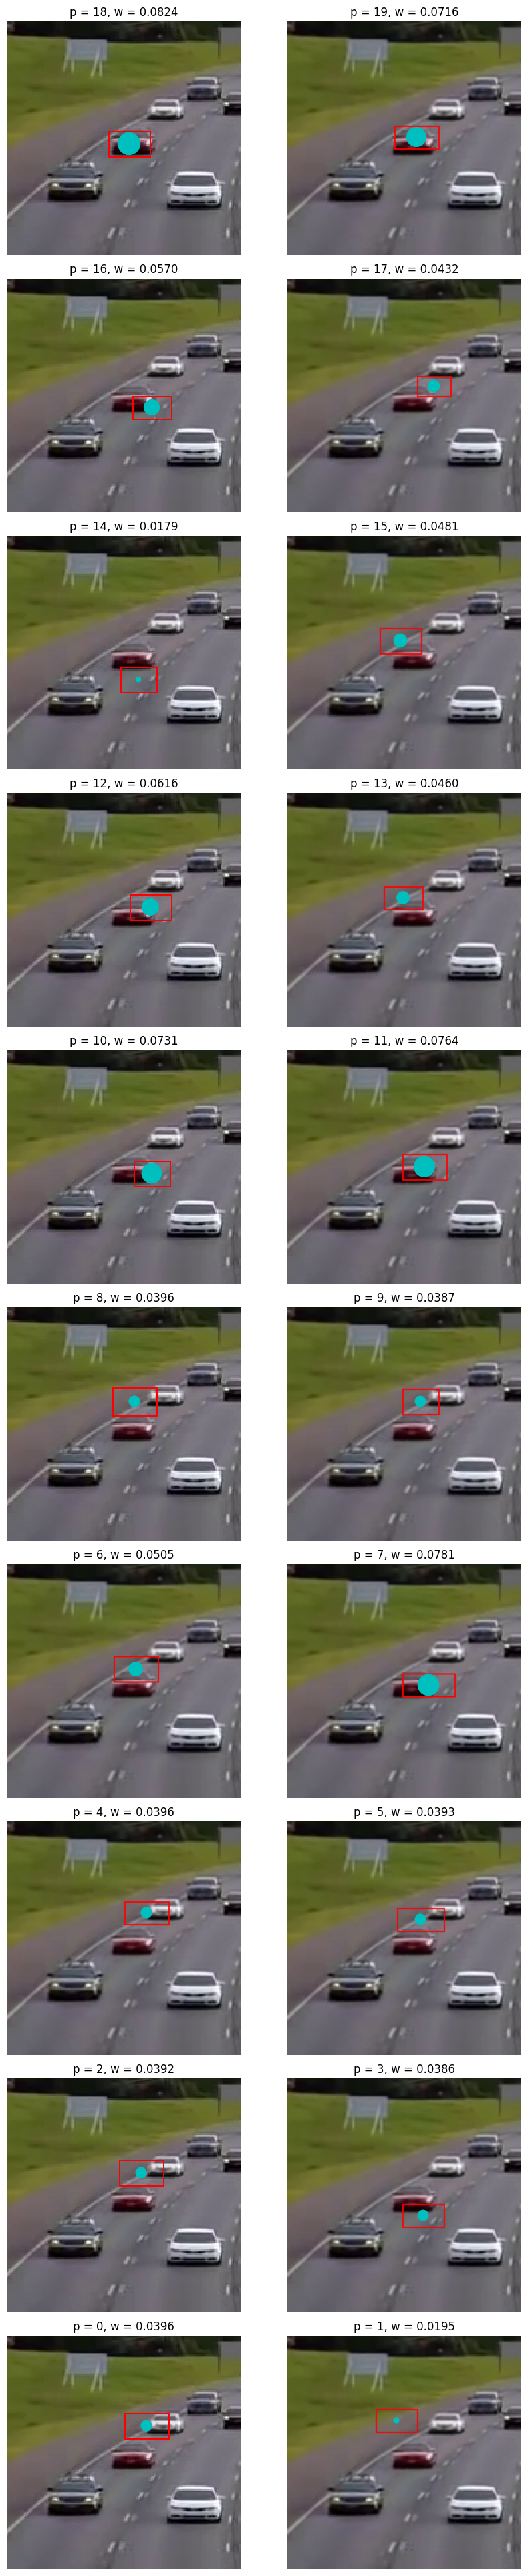

In [34]:
# Plot each particle separately. 
if num_particles <= 20:

    fig_cols = 2
    fig_rows = int(np.round(num_particles/2))

    fig,axs = plt.subplots(fig_rows,fig_cols,figsize=(15,90))
    size = 2.0
    hsep = 0.2
    vsep = 0.1
    for ii in range(0,fig_rows):
        h = axs[ii,0].imshow(cv2.rectangle(ima1_crop.copy(),(particles1_crop[2*ii,0]-particles1_crop[2*ii,2], particles1_crop[2*ii,1]-particles1_crop[2*ii,3]),(particles1_crop[2*ii,0]+particles1_crop[2*ii,2]+1, particles1_crop[2*ii,1]+particles1_crop[2*ii,3]+1),(255,0,0),1))
        axs[ii,0].set_axis_off()
        dpi = h.figure.get_dpi()/size
        h.figure.set_figwidth (ima1_crop.shape[1]/dpi)
        h.figure.set_figheight(ima1_crop.shape[0]/dpi)
        h.figure.canvas.resize(ima1_crop.shape[1] + 1, ima1_crop.shape[0] + 1)
        axs[ii,0].set_position([0, ii*(1+vsep), 1, 1])

        circle1 = plt.Circle((particles1_crop[2*ii,0], particles1_crop[2*ii,1]), weights1[2*ii]*100, color='c')
        axs[ii,0].add_patch(circle1)

        axs[ii,0].set_title('p = {}, w = {:.4f}'.format(2*ii, weights1[2*ii]))

        if ii+1 != num_particles:
            h = axs[ii,1].imshow(cv2.rectangle(ima1_crop.copy(),(particles1_crop[2*ii+1,0]-particles1_crop[2*ii+1,2], particles1_crop[2*ii+1,1]-particles1_crop[2*ii+1,3]),(particles1_crop[2*ii+1,0]+particles1_crop[2*ii+1,2]+1, particles1_crop[2*ii+1,1]+particles1_crop[2*ii+1,3]+1),(255,0,0),1))
            axs[ii,1].set_axis_off()
            dpi = h.figure.get_dpi()/size
            h.figure.set_figwidth (ima1_crop.shape[1]/dpi)
            h.figure.set_figheight(ima1_crop.shape[0]/dpi)
            h.figure.canvas.resize(ima1_crop.shape[1] + 1, ima1_crop.shape[0] + 1)
            axs[ii,1].set_position([1+hsep, ii*(1+vsep), 1, 1])

            circle1 = plt.Circle((particles1_crop[2*ii+1,0], particles1_crop[2*ii+1,1]), weights1[2*ii+1]*100, color='c')
            axs[ii,1].add_patch(circle1)

            axs[ii,1].set_title('p = {}, w = {:.4f}'.format(2*ii+1, weights1[2*ii+1]))

    plt.tight_layout()

    # show the graph
    plt.show()


## Propagation with dynamics model

Now, let's assume thatwe know the approximate motion model. We will use a constant velocity motion model. In this case, the state vector is:

$x = [c_x, c_y, v_x, v_y, w/2, h/2, v_w, v_h]$

where $v_x,v_y$ are the horizontal and vertical components of the velocity of the object, and $v_w, v_h$ are the velocities of growth of the bounding box.

Let's define the parameters:

In [35]:
num_particles_mm = 30
sigma_mm = [4,4,1,1,1,1,1,1]  # Variances along the different dimensions

dt = 1  # Increment of time

# Motion model (D in the slides)
cv_motion = np.array([[1, 0, dt, 0, 0, 0,  0,  0],
                      [0, 1, 0, dt, 0, 0,  0,  0],
                      [0, 0, 1,  0, 0, 0,  0,  0],
                      [0, 0, 0,  1, 0, 0,  0,  0],
                      [0, 0, 0,  0, 1, 0, dt,  0],
                      [0, 0, 0,  0, 0, 1,  0, dt],
                      [0, 0, 0,  0, 0, 0,  1,  0],
                      [0, 0, 0,  0, 0, 0,  0,  1]])

# Ground Truth: True states for three frames: [cx,cy,vx,vy,w/2,h/2,vw,vh]
# Obtained manually. Used to evaluate the results. 
tst_mm = np.array([[551,259,-6,6, 15,9, 2, 1],[545,265,-8,7,17,10,1,0],[537,272,-8,7,18,10,1,1]])

Note that we use smaller values for sigma_mm, the parameter that controls the difussion step, because we are using a synamics model to account for the object motion.

In [36]:
# Create a set of particles by repeating the state at k=0
particles0_mm = np.repeat([tst_mm[0,:]],num_particles_mm, axis=0)

# Apply difussion to the particles using a normal distribution centered in each particle
rng = np.random.default_rng(seed=42)
particles0_mm = rng.normal(particles0_mm, sigma_mm)

# Assign equal weights to the particles
weights0_mm   = 1.0 / num_particles_mm

Now, the we step from $k=0$ to $k=1$. We receive the current measurement and we  apply the motion model to each particle:


In [37]:
# Receive an observation for current time instant
name1 = 'out_000010.png'  # image at k=1  
ima1  = cv2.imread(name1)

# Convert image to L·a·b color space
ima1_lab = cv2.cvtColor(ima1,cv2.COLOR_BGR2Lab)
ima1_rgb = cv2.cvtColor(ima1,cv2.COLOR_BGR2RGB)
ima1_rgb_rect = ima1_rgb.copy()

# Apply motion model
particles1_mm = np.zeros_like(particles0_mm)
for ii in range (num_particles_mm):
    particles1_mm[ii,:] = np.dot(cv_motion, particles0_mm[ii,:])
particles1_mm = np.round(particles1_mm).astype(int)

We can compute the weights:

In [38]:
likelihood_mm = np.zeros(num_particles_mm)
for ii in range(num_particles_mm):
    model = ima1_lab[particles1_mm[ii,1]-particles1_mm[ii,5]:particles1_mm[ii,1]+particles1_mm[ii,5]+1,particles1_mm[ii,0]-particles1_mm[ii,4]:particles1_mm[ii,0]+particles1_mm[ii,4]+1,:]
    particle_hist = cv2.calcHist( [model], [1, 2], None, [16,16], ranges)
    particle_hist = particle_hist.flatten() / (np.sum(particle_hist.flatten())+epsilon) # Normalize histogram

    # Compute likelihood of the particle
    likelihood_mm[ii] = cv2.compareHist(target_hist, particle_hist, cv2.HISTCMP_INTERSECT)

# Normalize likelihoods and compute normalized weights
weights1_mm = likelihood_mm / np.sum(likelihood_mm)

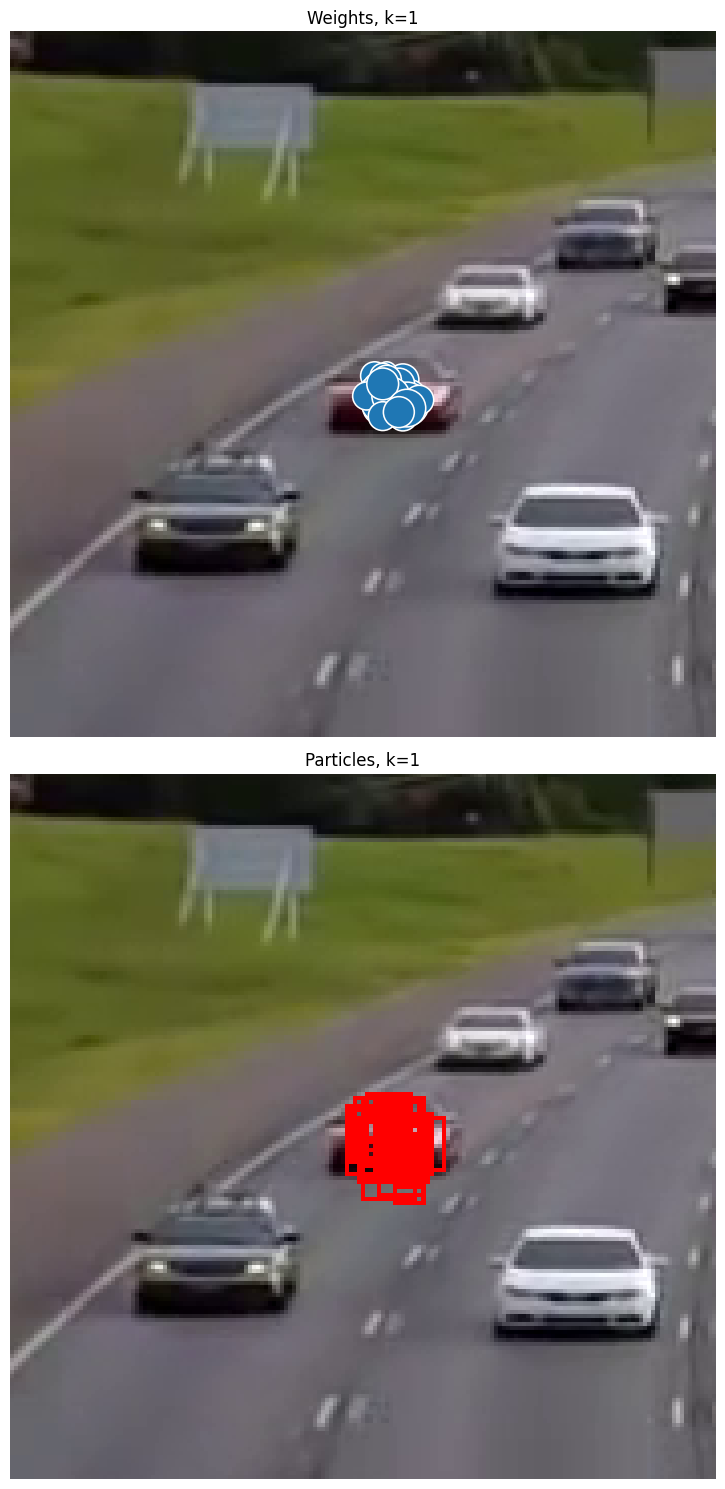

In [39]:
# Zoom of the region of interest. Not useful if the number of particles is large

ima1_crop          = ima1_rgb[175:350, 450:625]
ima1_rect_crop     = ima1_crop.copy()
particles1_mm_crop = particles1_mm.copy()

for ii in range(num_particles_mm):
    particles1_mm_crop[ii,0:2] = particles1_mm_crop[ii, 0:2] - np.array([450,175])
    cv2.rectangle(ima1_rect_crop,(particles1_mm_crop[ii,0]-particles1_mm_crop[ii,2], particles1_mm_crop[ii,1]-particles1_mm_crop[ii,3]),(particles1_mm_crop[ii,0]+particles1_mm_crop[ii,2]+1, particles1_mm_crop[ii,1]+particles1_mm_crop[ii,3]+1),(255,0,0),1)

fig,ax = plt.subplots(2,1,figsize=(15,15))
ax[0].imshow(ima1_crop)
sns.scatterplot(x=particles1_mm_crop[:,0], y=particles1_mm_crop[:,1], size=weights1_mm, legend=False, sizes=(10, 1000), ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Weights, k=1')

ax[1].imshow(ima1_rect_crop)
ax[1].set_axis_off()
ax[1].set_title('Particles, k=1')

plt.tight_layout()

# show the graph
plt.show()

Now we can estimate the state at $k=1$:

In [40]:
from iou import iou

# Estimate state: averaged sum
state_avg = np.sum(particles1_mm * weights1_mm[:,None], axis=0).astype(int)

# Estimate state: particle with largest weight
state_lw = particles1_mm[np.argmax(weights1_mm)]

print ('Average:        ', state_avg)
print ('Highest weight: ', state_lw)
print ('True state:     ', tst_mm[1,:])

# Bounding box of the true state
bb_tst = {'x1':tst_mm[1,0]-tst_mm[1,4], 'y1':tst_mm[1,1]-tst_mm[1,5],'x2':tst_mm[1,0]+tst_mm[1,4], 'y2':tst_mm[1,1]+tst_mm[1,5]}
# Bounding box of the solution using the average
bb_avg = {'x1':state_avg[0]-state_avg[4], 'y1':state_avg[1]-state_avg[5], 'x2':state_avg[0]+state_avg[4], 'y2':state_avg[1]+state_avg[5]}
# Bounding box of the solution using the largest weight
bb_lw  = {'x1':state_lw[0]-state_lw[4], 'y1':state_lw[1]-state_lw[5], 'x2':state_lw[0]+state_lw[4], 'y2':state_lw[1]+state_lw[5]}

# Compute Intersection over Union to evaluate the solution. Higher values are 
# better. IoU is bounded in [0,1]. In object detection an IoU >= 0.5 is usually 
# considered a correct detection.
print ('IOU avg  = {:.3f}'.format(iou(bb_tst, bb_avg)))
print ('IOU best = {:.3f}'.format(iou(bb_tst, bb_lw)))

Average:         [544 265  -5   6  16   9   1   0]
Highest weight:  [548 267  -5   6  15   8   0   0]
True state:      [545 265  -8   7  17  10   1   0]
IOU avg  = 0.733
IOU best = 0.581


Let's check if there is degeneracy:

In [41]:
ESS = 1.0 / np.sum(weights1_mm**2)
print ('ESS = {}'.format(ESS))

ESS = 29.843892128490424


If $ESS \lt N_s/2$ there is degeneracy and we should resample. In this case, we will resample regardless of the value of $ESS$:

In [42]:
from filterpy import monte_carlo

idx_resampling = monte_carlo.resampling.residual_resample(weights1_mm)

particles1_mm = particles1_mm[idx_resampling]

# Apply difussion to the particles using a normal distribution centered in each particle
rng = np.random.default_rng(seed=42)
particles1_mm = rng.normal(particles1_mm, sigma_mm)

particles1_mm = np.round(particles1_mm).astype(int)

# All resulting particles are re-weighted
weights1_mm = np.ones(num_particles_mm) * (1.0/num_particles_mm)  

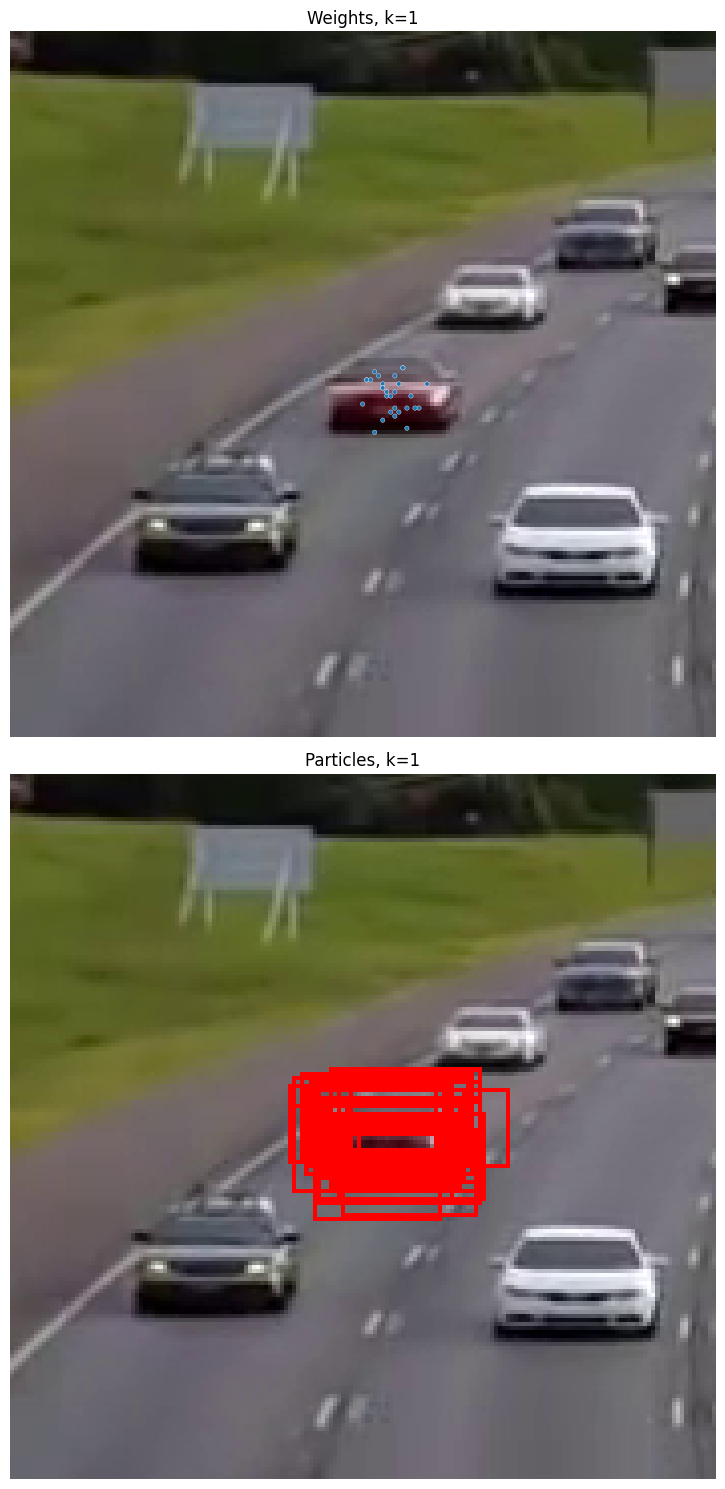

In [43]:
# Zoom of the interest region. Not useful if the number of particles is large

ima1_crop       = ima1_rgb[175:350, 450:625]
ima1_rect_crop  = ima1_crop.copy()
particles1_mm_crop = particles1_mm.copy()

for ii in range(num_particles_mm):
    particles1_mm_crop[ii,0:2] = particles1_mm_crop[ii, 0:2] - np.array([450,175])
    cv2.rectangle(ima1_rect_crop,(particles1_mm_crop[ii,0]-particles1_mm_crop[ii,4], particles1_mm_crop[ii,1]-particles1_mm_crop[ii,5]),(particles1_mm_crop[ii,0]+particles1_mm_crop[ii,4]+1, particles1_mm_crop[ii,1]+particles1_mm_crop[ii,5]+1),(255,0,0),1)

fig,ax = plt.subplots(2,1,figsize=(15,15))
ax[0].imshow(ima1_crop)
sns.scatterplot(x=particles1_mm_crop[:,0], y=particles1_mm_crop[:,1], size=weights1_mm, legend=False, sizes=(10, 1000), ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title('Weights, k=1')

ax[1].imshow(ima1_rect_crop)
ax[1].set_axis_off()
ax[1].set_title('Particles, k=1')

plt.tight_layout()
plt.show()

Now, the we step from $k=1$ to $k=2$. 

In [46]:
from iou import iou

# Receive observation for current time instant
name2 = 'out_000020.png'  # image at k=2
ima2  = cv2.imread(name2)

# Convert image to L·a·b color space
ima2_lab = cv2.cvtColor(ima2,cv2.COLOR_BGR2Lab)
ima2_rgb = cv2.cvtColor(ima2,cv2.COLOR_BGR2RGB)
ima2_rgb_rect = ima1_rgb.copy()


# Apply motion model
particles2_mm = np.zeros_like(particles1_mm)
for ii in range (num_particles_mm):
    particles2_mm[ii,:] = np.dot(cv_motion, particles1_mm[ii,:])
particles2_mm = np.round(particles2_mm).astype(int)

# Compute likelihood
likelihood_mm = np.zeros(num_particles_mm)
for ii in range(num_particles_mm):
    model = ima2_lab[particles1_mm[ii,1]-particles1_mm[ii,5]:particles1_mm[ii,1]+particles1_mm[ii,5]+1,particles1_mm[ii,0]-particles1_mm[ii,4]:particles1_mm[ii,0]+particles1_mm[ii,4]+1,:]
    particle_hist = cv2.calcHist( [model], [1, 2], None, [16,16], ranges)
    particle_hist = particle_hist.flatten() / (np.sum(particle_hist.flatten())+epsilon) # Normalize histogram

    # Compute likelihood of the particle
    likelihood_mm[ii] = cv2.compareHist(target_hist, particle_hist, cv2.HISTCMP_INTERSECT)

# Normalize likelihoods and compute normalized weights
weights2_mm = likelihood_mm / np.sum(likelihood_mm)

# Estimate state: averaged sum
state_avg = np.sum(particles2_mm * weights2_mm[:,None], axis=0).astype(int)

# Estimate state: particle with largest weight
state_lw = particles2_mm[np.argmax(weights2_mm)]

print ('Average:        ', state_avg)
print ('Highest weight: ', state_lw)
print ('True state:     ', tst_mm[1,:])

# Bounding box of the true state
bb_tst = {'x1':tst_mm[2,0]-tst_mm[2,4], 'y1':tst_mm[2,1]-tst_mm[2,5],'x2':tst_mm[2,0]+tst_mm[2,4], 'y2':tst_mm[2,1]+tst_mm[2,5]}
# Bounding box of the solution using the average
bb_avg = {'x1':state_avg[0]-state_avg[4], 'y1':state_avg[1]-state_avg[5], 'x2':state_avg[0]+state_avg[4], 'y2':state_avg[1]+state_avg[5]}
# Bounding box of the solution using the largest weight
bb_lw  = {'x1':state_lw[0]-state_lw[4], 'y1':state_lw[1]-state_lw[5], 'x2':state_lw[0]+state_lw[4], 'y2':state_lw[1]+state_lw[5]}

# Compute Intersection over Union to evaluate the solution. Higher values are 
# better. IoU is bounded in [0,1]. In object detection an IoU >= 0.5 is usually 
# considered a correct detection.
print ('IOU avg  = {:.3f}'.format(iou(bb_tst, bb_avg)))
print ('IOU best = {:.3f}'.format(iou(bb_tst, bb_lw)))


Average:         [538 271  -5   6  18   9   2   0]
Highest weight:  [534 276  -8   5  17  10   1   1]
True state:      [545 265  -8   7  17  10   1   0]
IOU avg  = 0.741
IOU best = 0.512
